In [16]:
#----------------------------------1st block of code------------------------------------------

import os
import math
import numpy as np
import skimage
import matplotlib.pyplot as plt

from skimage import io
#import imageio.v2 as imageio

# Mac path format: /Users/username/folder/file.tif
# Windows path format: C:\\folder\\file.tif

PathName = "F:\\IsabelG\\102425-inverted"

os.chdir(PathName)

orgfilenames = os.listdir(PathName) # list all files in Pathname and store in orgfilename
filenames = [] # empty list for pgm files
for m in range(len(orgfilenames)):
	test = orgfilenames[m]
	if (len(test) > 3) and (test[-3:] == 'pgm'): #checks if filename longer than 3 characters and ends with pgm
		filenames.append(orgfilenames[m]) #adds the filename to filenames list

frameSize= frame_no=len(filenames) 

picture = skimage.io.imread(filenames[0]) #loads the first image as grayscale 
h,w=picture.shape #extracts the hieght and width of image

#del picture 

# Create AVG of inverted images
# File too large to do one large average, so need to chunk.

avg_load = np.zeros((h, w, math.ceil(frame_no / 50))) #creates NumPy array of 0s to store average images
                                                      #each slice will hold the average of 50 inverted images
                                                      #math.ceil ensures this works even if number is not divisible by 50

for frames in range(math.ceil(frame_no/50)):
    temp_stack = np.zeros((h, w, 50),np.dtype(np.uint8)) #temporary 3D array to store inverted images as uint 8
    for sub_frames in range(50): 
        if frames * 50 +sub_frames < frame_no: #   
            oneimage = skimage.io.imread(filenames[frames*50 + sub_frames])  #loads image in filenames
            temp_stack[:,:,sub_frames] = 255-oneimage                        #inverts the image
        else:
              break
    avg_load[:, :, frames] = np.mean(temp_stack, axis=2)                 #gives average of the 50 inverted images and stores in the avg_load array

del oneimage #frees memory

del temp_stack  
Total_AVG = np.mean(avg_load, axis=2) #averages the average images to get one 2D image
Total_AVG = Total_AVG.astype(np.uint8) # converts the image to integers

del avg_load #frees memory

In [17]:
#----------------------------------2nd block of code------------------------------------------

from skimage.morphology import disk, dilation, erosion
import math
#from numba import jit
import numpy as np

import os
import matplotlib.pyplot as plt
#import matplotlib
#from skimage import data
import skimage
import datetime

#from Initial import PathName, frame_no, filenames, Total_AVG
os.chdir(PathName)

## ---- VARIABLES TO TOY AROUND WITH --- ##

std_num = 0.04 #if increased = reference image brighter; contrast between reference image and worm is decreased
loop_erode = 2 #how many times erosion is applied (erase borders of items)
loop_dilate = 3 #how many times dilation is applied (add borders to items)
disk_erode = 1 #size of erosion (aka size of eraser)
disk_dilate = 1 #size of how many pixels added back to eroded item, if you dilate too much it cant detect the worm moving
areas = 2 #tell the script how many areas to look for (areas * worm num), encourages code to look for particles
numberOfWorms = 6 #there are only 4 worms visible in the cropped image, but let's try detecting more
bnum = 1000 #cropping
endnum = 2000 #cropping

# Don't need to change these, but these are our test parameters
#frameSize = 5368 #just do 10 frames to test for now

## ------------------------------------- ##


# Subfunctions
def binarizeFrame(x, filenames, avgFrame, disk1, disk2):
    #a = datetime.datetime.now()
    #print(skimage.io.imread(filenames[x]))
    temp = (255-skimage.io.imread(filenames[x])) - avgFrame 
    bgsub = skimage.io.imread(filenames[x]) - avgFrame
    thresh = np.median(temp[:]) + (np.std(temp[:])*std_num) #can toy around with, can increase std
    Binary = temp > thresh

    #-----------substracting background from original images (not binary)-------
    # fig, ax = plt.subplots(1,1, figsize=(10,10), facecolor='w')
    # ax.imshow(bgsub[1000:2000, 1000:2000], aspect='auto', cmap='gray', vmin=0, vmax=255)
    # ax.set_title('Frame: ' + str(x))
    # plt.show()
    #------------------------------- Printing the average
    # print(temp)
    # print(thresh)
    # print(Binary)
    # fig, ax = plt.subplots(1,1, figsize=(10,10), facecolor='w')
    #plt.imshow(image[1000:2000,1000:2000], aspect='auto', cmap='gray', vmin = 0, vmax = 255, alpha=1)
    # plt.imshow(temp[1000:2000,1000:2000], aspect='auto', cmap='gray', vmin = 0, vmax = 255, alpha=1)
    # fig, ax = plt.subplots(1,1, figsize=(10,10), facecolor='w')
    # ax.imshow(Binary[1000:2000,1000:2000], aspect='auto', cmap='gray', interpolation='nearest', alpha=0.5)
    # plt.title('Frame: '+str(frameChoice))
    # plt.show()
    # print(np.shape(Binary)) #len(blah)
    # b = datetime.datetime.now()
    
    #c = b-a
    #print("Binarizing: ", c)
    
    #d = datetime.datetime.now()
    image1_erode = Binary
    for k1 in range(loop_erode):
        image1_erode = erosion(image1_erode) #if get error: change to footprint, selem is deprecated
    #e = datetime.datetime.now()
    
    #f = e - d
    #print("Eroding:    ", f)
    
    #g = datetime.datetime.now()    
    image1_dilation = image1_erode
    for k2 in range(loop_dilate):
        image1_dilation = dilation(image1_dilation) #if get error: change to footprint, selem is deprecated
    
    #h = datetime.datetime.now()
    
    #i = h - g
    #print("Dilating:   ", i)
    
    #j = h - a
    #print("Total:      ", j)
    
    return image1_dilation

def calculateD(x1,y1,x2,y2):
    XDistance = x2 - x1
    YDistance = y2 - y1
    pointDistance = math.sqrt(pow(XDistance,2) + pow(YDistance,2))
    return pointDistance

#Some Necessary Variables
se1 = disk(disk_erode) #disk size down to one, use absolute threshold after inverting and subtracting
se2 = disk(disk_dilate)

distanceThreshold = 20 # The code will look for the worm in this distance from the last known position of the worm
#distanceThreshold = np.zeros(numberOfWorms)
#previousCentroid = np.zeros((numberOfWorms,2))
#Distance = 0 #can change

currentFrame_test = binarizeFrame(0, filenames, Total_AVG, se1, se2)
currentFrame_test2 = currentFrame_test[bnum:endnum,bnum:endnum]
labels_test = skimage.measure.label(currentFrame_test2)
particle_data_test = skimage.measure.regionprops(labels_test)
# print('how many particles detected in frame 0?', len(particle_data_test))
new_len = len(particle_data_test)



particle_tracking_centroid = np.zeros((new_len,frameSize,2))
particle_tracking_area = np.zeros((new_len,frameSize,5))
previousCentroid = np.zeros((new_len,2))

particle_tracking_eccentricity = np.zeros((new_len,frameSize,1)) #shape of particle

## Start of looping through code ##

for frameChoice in range(frameSize):
    currentFrame1 = binarizeFrame(frameChoice, filenames, Total_AVG, se1, se2)
    currentFrame = currentFrame1[bnum:endnum,bnum:endnum]
    # image_file = f"currentFrame_{frameChoice}.pgm"   # append iteration number
    # imageio.imwrite(image_file, (currentFrame * 255).astype(np.uint8))
    # fig, ax = plt.subplots(1,1, figsize=(10,10), facecolor='w')
    # ax.imshow(currentFrame, aspect='auto', cmap='Wistia', interpolation='nearest', alpha=0.5)
    # plt.imshow(Total_AVG[1000:2000,1000:2000], aspect='auto', cmap='gray', vmin = 0, vmax = 250, alpha=0.5)
    # plt.title('Frame: '+str(frameChoice))
    # plt.show()

    # y = datetime.datetime.now()
    labels = skimage.measure.label(currentFrame)
    particle_data = skimage.measure.regionprops(labels) #looks for any isolation of pixels, can get area and image properties
    # print('how many particles detected in frame' , frameChoice, ' ?', len(particle_data))
    #particle_data.area, .centroid
    
    if len(particle_data)>0:
        particle_data = sorted(particle_data, key=lambda p: p.area, reverse=True)
        
        #Setting up the First Frame
        if frameChoice == 0:
            for wormIndex in range(len(particle_data)): #try printing actual image and plot circle around 
                #centroid to see if it matches worm, see what is inputed in particle tracking, 
                #get centroid and area
                # print('centroid, frame1', particle_data[wormIndex].centroid) ------------------------------------------------------------------------------------------------------------
                particle_tracking_centroid[wormIndex,frameChoice,:] = particle_data[wormIndex].centroid
                particle_tracking_eccentricity[wormIndex,frameChoice,0] = particle_data[wormIndex].eccentricity
                previousCentroid[wormIndex,:] = particle_tracking_centroid[wormIndex,frameChoice,:]
                #print('prev1', previousCentroid[wormIndex,:])
                #distanceThreshold[wormIndex] = 5
                
                # fig, ax = plt.subplots(1,1, figsize=(10,10), facecolor='w')
                # plt.imshow(Total_AVG[1000:2000,1000:2000], aspect='auto', cmap='gray', vmin = 0, vmax = 255, alpha=0.5)    
                # ax.imshow(currentFrame, aspect='auto', cmap='Wistia', interpolation='nearest', alpha=0.5)
                # plt.plot(particle_tracking_centroid[wormIndex,frameChoice,1], particle_tracking_centroid[wormIndex,frameChoice,0], 'ro')
                # plt.plot(340, 970, 'go', alpha=0.7)
                # plt.plot(585, 930, 'go', alpha=0.7)
                # plt.plot(690, 900, 'go', alpha=0.7)
                # plt.plot(400, 435, 'go', alpha=0.7)
                # ax.yaxis.set_inverted(True)
                # plt.title('First frame, worm: ' + str(wormIndex))
                # plt.show()
            
        #check the distance with the previous center
        else:
            #loop through the first (numberOfWorms*2 or length(areas)) largest areas to check if the distance within Threshold for each worm  
            numberOfAreas = (numberOfWorms * areas)
            if numberOfAreas > len(particle_data):
                numberOfAreas = len(particle_data)
            #print(numberOfAreas)
            #declare variable for areas already assigned to worm, so two worms won't be assigned to same area 
            areaMatched = np.zeros(numberOfAreas)

            for wormIndex in range(numberOfAreas): ##
                try:
                    previousX2 = previousCentroid[wormIndex,0]
                    previousY2 = previousCentroid[wormIndex,1]
                except:
                    continue
                
                #declare variable to check if area is found at a distance within threshold
                found = False
                
                for areaNumber in range(numberOfAreas):
                    # if the area is already assigned to another worm, skip it, contiune to the next area
                    if areaMatched[areaNumber] == 1:
                        continue
                    #can speed this up by just comparing distance of previous centroid (above) 
                    # and centroid (below .centroid)
                    # use code andrew sent calculating distances
                     
                    currentX1, currentY1  = particle_data[areaNumber].centroid
                
                    #distance of current area to this worm
                    Distance = calculateD(currentX1,currentY1,previousX2,previousY2)
                    #print('distance', Distance, ', worm', wormIndex, 'frame', frameChoice)

                    #print just distances to take average for optimizing video taking
                   # print(Distance)

                    # Find an area within threshold
                    if Distance <= distanceThreshold:
                        particle_tracking_centroid[wormIndex,frameChoice,:] = particle_data[areaNumber].centroid
                        particle_tracking_eccentricity[wormIndex,frameChoice,0] = particle_data[areaNumber].eccentricity
                        previousCentroid[wormIndex,:] = particle_tracking_centroid[wormIndex,frameChoice,:]
                        #distanceThreshold[wormIndex] = 5
                     
                        areaMatched[areaNumber] = 1
                        found = True
                             
                        #draw image        
                        particle_tracking_area[wormIndex, frameChoice] = particle_data[areaNumber].area
                        #print(particle_tracking_area)
                        #print('centroid', particle_data[wormIndex].centroid, ', worm', wormIndex)
                        # fig, ax = plt.subplots(1,1, figsize=(10,10), facecolor='w')
                        # ax.imshow(currentFrame, aspect='auto', cmap='Wistia', interpolation='nearest', alpha=0.5)
                        # plt.imshow(Total_AVG[1000:2000,1000:2000], aspect='auto', cmap='gray', vmin = 0, vmax = 250, alpha=0.5)
                        # plt.plot(particle_tracking_centroid[wormIndex,frameChoice,1], particle_tracking_centroid[wormIndex,frameChoice,0], 'ro')
                        # plt.plot(340, 970, 'go', alpha=0.7)
                        # plt.plot(585, 930, 'go', alpha=0.7)
                        # plt.plot(690, 900, 'go', alpha=0.7)
                        # plt.plot(400, 435, 'go', alpha=0.7)
                        # #ax.set(xlim=(0, 3236), xticks=np.arange(0, 3236, 500), ylim=(0, 3648), yticks=np.arange(0, 3648, 500))
                        # #ax.set(xlim=(1000, 2000), xticks=np.arange(1000, 2000, 500), ylim=(1000, 2000), yticks=np.arange(1000, 2000, 500))
                        # ax.yaxis.set_inverted(True)
                        # #fig = plt.figure()
                        # #ax = fig.add_subplot(111)
                        # #ax.imshow(currentFrame, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
                        # plt.title('Frame: '+str(frameChoice) + ', worm: ' + str(wormIndex))
                        # plt.show()
        
                        break
                
                # if found is still false, then no area is within the threashold 
                # set centroid to NaN and double the threshold, and move to next frame
                if found == False:
                    particle_tracking_centroid[wormIndex, frameChoice,:] = np.zeros((1,2))
                    #distanceThreshold[wormIndex] = distanceThreshold[wormIndex] * 2
                    #print('FAILED - worm number:' ,str(wormIndex) ,', frame number:', str(frameChoice) )
            
    # z = datetime.datetime.now()
    # print("RunTime: ", z-y)
    # print('\n')

print('Done')

Done


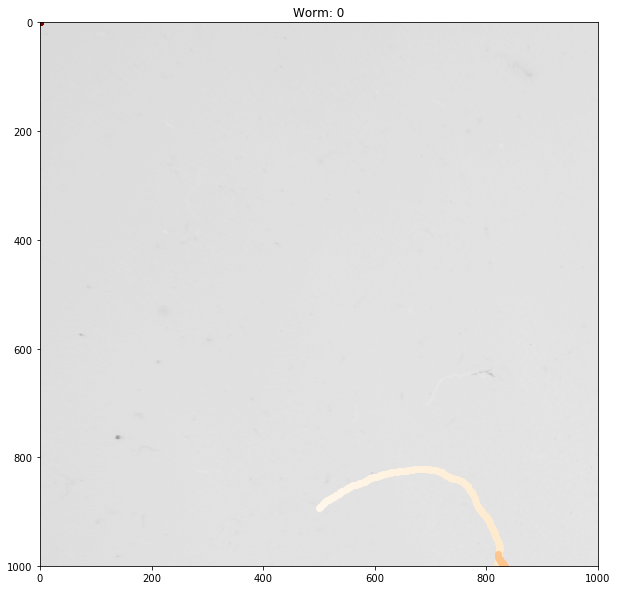

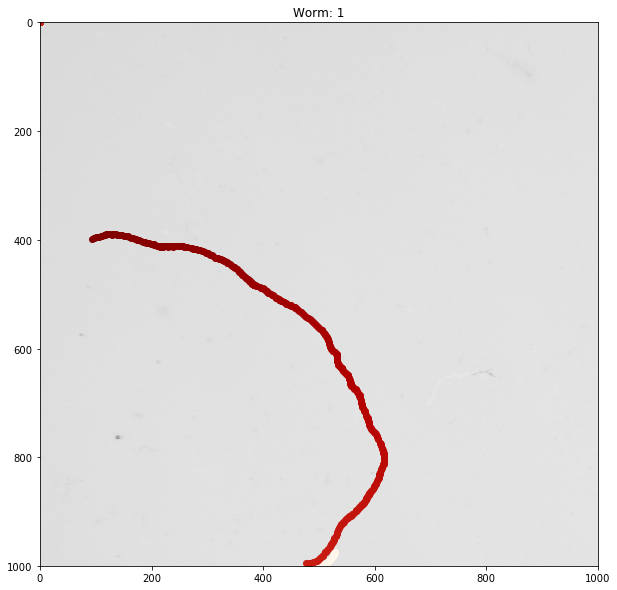

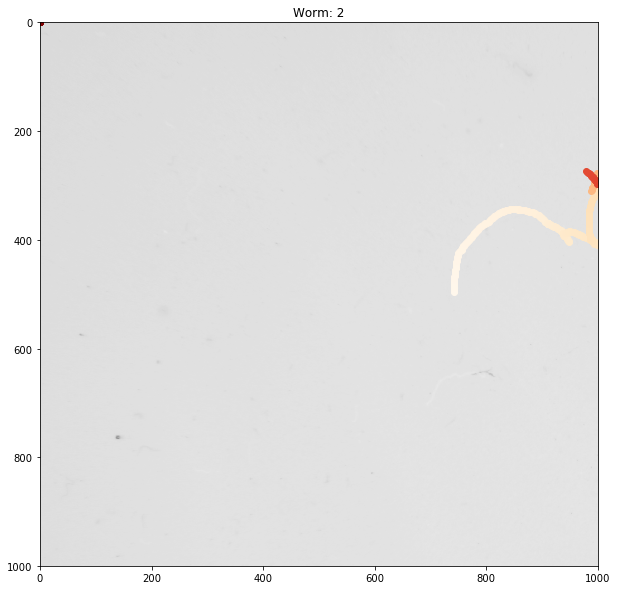

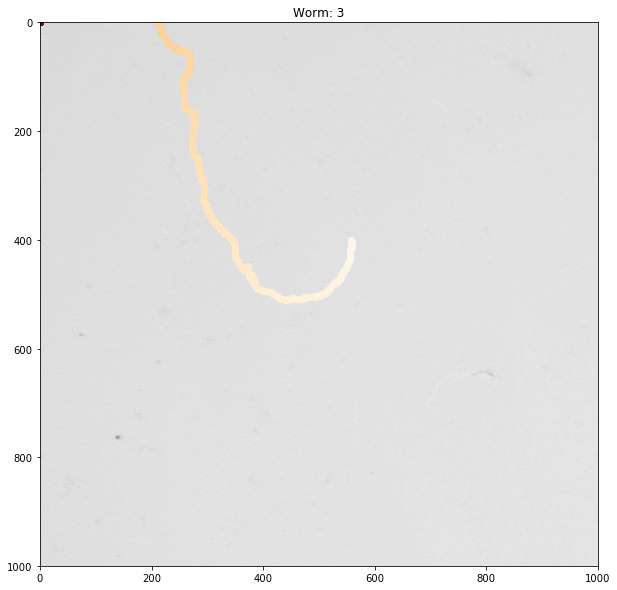

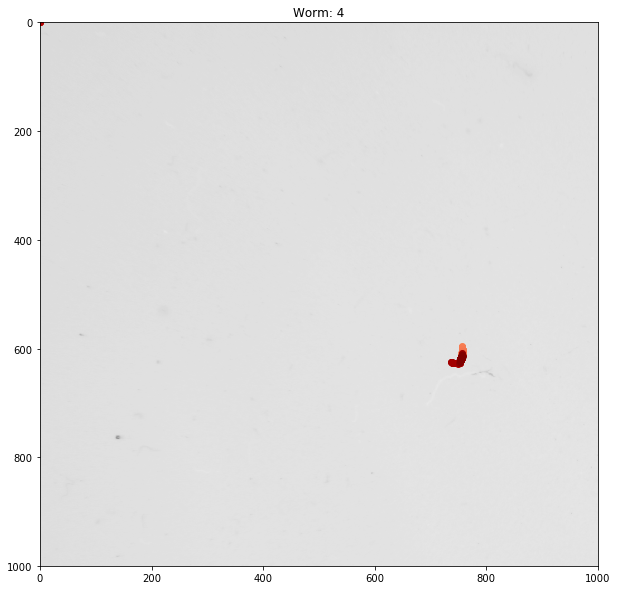

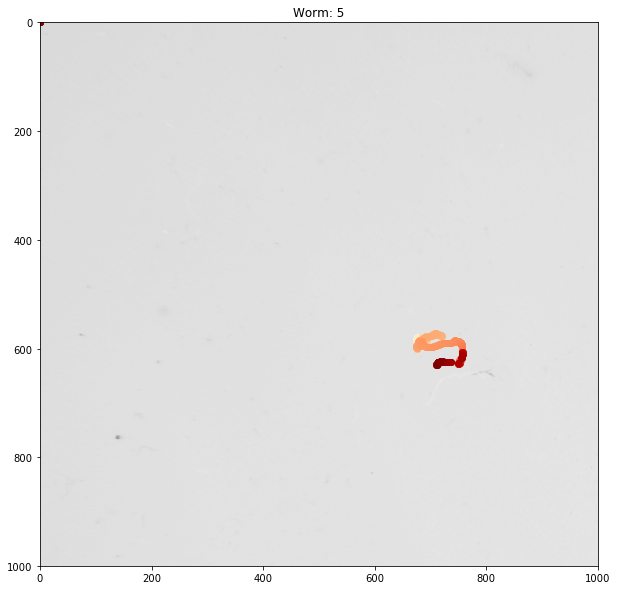

In [18]:
#-------------------------------------Visualizing Worm Paths-------------------------------------------------------------------
# Compare output below of x,y coordinates to these coordinates (which are the actual coords of the worm) #
# Don't have to be exact match, just check if it's close to these coords #
# worm coord: (340, 970)
# worm coord: (585, 930)
# worm coord: (690, 900)
# worm coord: (400, 435)

# Check to see if there are zeros, that means it failed to find the worm in that frame #
# Goal: try to find parameters that minimize or eliminate zeros.

# We're going to initialize our search with more particles than worms to force the code to find the correct thing.
# Check to see if after the first frame, there are a bunch of zeros. That means the particle is not a worm. 
# If it has multiple coordinates, that IS a worm -- print out xy coords please.
from matplotlib import cm
colormap = cm.get_cmap('OrRd', frameSize)
for worm in range(len(particle_tracking_centroid)):
#print(particle_tracking_centroid[worm])
    if np.all(particle_tracking_centroid[worm][1:] == 0) == True:
        print('not a worm :( ', worm)
    else:
        fig, ax = plt.subplots(1,1, figsize=(10,10), facecolor='w')
        for frame in range(frameSize):
            #print(particle_tracking_centroid[worm,frame,:])
            # print('worm:', worm, ', frame:', frame)
            # print('(x,y):', particle_tracking_centroid[worm, frame, 1], particle_tracking_centroid[worm, frame, 0])
            # print('\n')
            plt.imshow(Total_AVG[bnum:endnum,bnum:endnum], aspect='auto', cmap='Greys', vmin = 0, vmax = 255, alpha=0.5)
            color = colormap(frame / (frameSize-1))
            # ax.yaxis.set_inverted(True)
            alpha_value = (frame + 1) / frameSize
            plt.plot(particle_tracking_centroid[worm,frame,1], particle_tracking_centroid[worm,frame,0], marker = 'o', color = color)
            plt.title('Worm: ' + str(worm) )
#             plt.plot(340, 970, 'go', alpha=0.7) #subtract 1000 from real coordinates since the image is cropped by 1000 pixels
#             plt.plot(585, 930, 'go', alpha=0.7)
#             plt.plot(690, 900, 'go', alpha=0.7)
#             plt.plot(400, 435, 'go', alpha=0.7)
            # plt.plot(664, 667, 'go', alpha=0.7)
            # plt.plot(666, 689, 'go', alpha=0.7)
            # plt.plot(812, 807, 'go', alpha=0.7)


In [14]:
#---------------------gives frames dropped (coordinates = 0,0)---------------------------------------------
for worm in range(len(particle_tracking_centroid)):
    dropped_frames = []
    
    # Check if all frames from 1 onwards have (0, 0) coordinates — not a worm
    if np.all(particle_tracking_centroid[worm][1:] == 0):
        print('not a worm :( ', worm )
        print()
    else:
        # Check each frame for (0, 0) — dropped frame
        for frame in range(particle_tracking_centroid.shape[1]):
            if np.all(particle_tracking_centroid[worm, frame, 1:] == 0):
                dropped_frames.append(frame)

        # Print based on whether any frames were dropped
        if dropped_frames:
            print(f'worm {worm}: ({", ".join(map(str, dropped_frames))})')
            print()
        else:
            print(f'worm {worm}: No dropped frames')
            print()
            


worm 0: No dropped frames

worm 1: No dropped frames

worm 2: No dropped frames

worm 3: (1, 5, 8, 9)

worm 4: (2, 7)

worm 5: No dropped frames

worm 6: No dropped frames

worm 7: No dropped frames

worm 8: No dropped frames

worm 9: (7, 9)

worm 10: (4, 5, 6, 7, 8, 9)

worm 11: (1, 2, 3, 4, 6, 7, 9)

worm 12: (2, 3, 4, 5, 6, 7, 8, 9)

worm 13: No dropped frames

worm 14: (1, 2, 3, 4, 9)

worm 15: (3, 5, 6, 7, 8, 9)

worm 16: (1, 3, 4, 5, 8)

worm 17: (2)

not a worm :(  18

not a worm :(  19

not a worm :(  20

not a worm :(  21

not a worm :(  22

not a worm :(  23

not a worm :(  24

not a worm :(  25

not a worm :(  26

not a worm :(  27

not a worm :(  28

not a worm :(  29

not a worm :(  30

not a worm :(  31

not a worm :(  32

not a worm :(  33

not a worm :(  34

not a worm :(  35

not a worm :(  36

not a worm :(  37

not a worm :(  38

not a worm :(  39

not a worm :(  40

not a worm :(  41

not a worm :(  42

not a worm :(  43

not a worm :(  44

not a worm :(  45

not a 

In [ ]:
#----------------------------------3rd block of code------------------------------------------
#import os
#import math
#import matplotlib.pyplot as plt
#import matplotlib
#import numpy as np

#from skimage import data
#import skimage

#Fill in NaN for centroids
#numberOfWorms = 7
#from findCentroidAreas import particle_tracking_centroid
#from Initial import frame_no
#frameSize = frame_no

for wormIndex in range(numberOfWorms):
  currentCentroid = particle_tracking_centroid[wormIndex,0,:] #centroild in the first frame
  beginningFrameChoice = 0
  endFrameChoice = 0
  TF1 = np.isnan(particle_tracking_centroid[wormIndex,:,0]) #boolean array that tells us if there is missing data
 
  for firstloop in range(len(particle_tracking_centroid[wormIndex,:,0])):
    #loop the centroid frame matrix, 
    #assign frames which are not NaN to BeginFrameChoice 
    if TF1[firstloop] == 0:
      beginningFrameChoice = firstloop
    else:
      #There is a frame with NaN 
      #Keep going through the following frames
      #Assign EndFrameChoice with the frame that is not NaN 
      for secondloop in range((firstloop + 1),len(particle_tracking_centroid[wormIndex,:,0])):
        if TF1[secondloop] == 0:
          endFrameChoice = secondloop
          break
        
      if (beginningFrameChoice < endFrameChoice): # getting the coordinates of the gap
        tempX1 = particle_tracking_centroid[wormIndex, beginningFrameChoice, 0]
        tempY1 = particle_tracking_centroid[wormIndex, beginningFrameChoice, 1]
        tempX2 = particle_tracking_centroid[wormIndex, endFrameChoice, 0]
        tempY2 = particle_tracking_centroid[wormIndex, endFrameChoice, 1]

        
        tempNumber = endFrameChoice - beginningFrameChoice
        tempAmountX = (tempX2 - tempX1)/tempNumber
        tempAmountY = (tempY2 - tempY1)/tempNumber
        
        numTimesMult = 1
    
        for nanAssignLoop in range((beginningFrameChoice + 1) , endFrameChoice):
          particle_tracking_centroid[wormIndex,nanAssignLoop,0] = tempX1 + (numTimesMult * tempAmountX) #why is it 1 and 2 and not 0 and 1
          particle_tracking_centroid[wormIndex,nanAssignLoop,1] = tempY1 + (numTimesMult * tempAmountY)
          TF1[nanAssignLoop] = 0
          numTimesMult = numTimesMult + 1 
          
for wormIndex in range(numberOfWorms):
    temp=np.squeeze(particle_tracking_centroid[wormIndex,:-1,:]) #remove singleton dimensions but why? 
    particle_tracking_centroid_shift = np.insert(temp,0,0,axis=0) #shift the data and add zeros in place why
    
    X_Y_Difference = np.squeeze(particle_tracking_centroid[wormIndex,:,:]) - particle_tracking_centroid_shift #removes dimensions that are size 
                                                                                                              #of 1 without deleting data
    
    X_Y_Distance = np.zeros((frameSize, 1))
    for i in range(0, len(X_Y_Difference)):
        tempX = X_Y_Difference[i, 0]
        tempY = X_Y_Difference[i, 1]
        Length = np.sqrt(math.sqrt(pow(tempX,2) + pow(tempY,2)))
        X_Y_Distance[i, 0] = Length
        if (X_Y_Distance[i, 0] > 10):
            X_Y_Distance[i,0] = 10
        
    
    #for i in range(0,len(X_Y_Distance)):
        #if(X_Y_Distance[i]) > 10
           # X_Y_Distance[i] = NaN
        
        
    #Plot Data
    ArraySize = np.arange(0,len(X_Y_Distance))
    plt.plot(ArraySize, X_Y_Distance)
    plt.show()
    

Tracked 6 worms with valid positions.


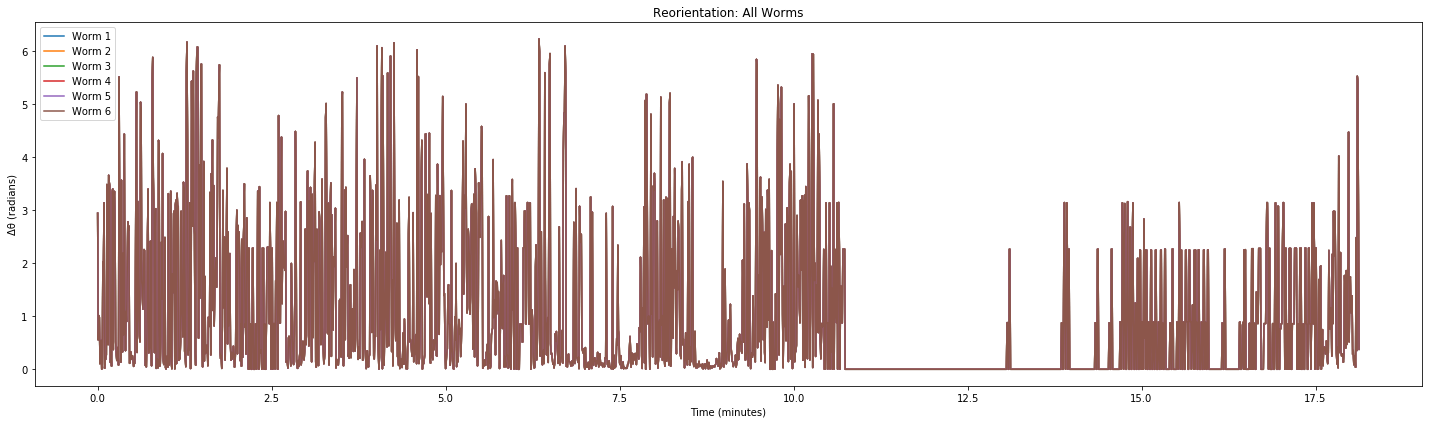

Average reorientation rate across all worms: 118.5183 radians/minute


In [116]:
#----------------------------------------------Reorientation graph and rates for all worms------------------------------------------------
frames_per_minute = 120      # frame rate
step = 4                     # number of frames between orientation calculations
colormap = cm.get_cmap('OrRd', frameSize)

avg_reorientation_rates = []
theta_all = []
worm_tracks = {}

for wormIndex in range(len(particle_tracking_centroid)):
    for frameChoice in range(frameSize):
        x, y = particle_tracking_centroid[wormIndex, frameChoice, :]
        if wormIndex not in worm_tracks:
            worm_tracks[wormIndex] = []
        worm_tracks[wormIndex].append((frameChoice, x, y))

print(f"Tracked {len(worm_tracks)} worms with valid positions.")


plt.figure(figsize=(20, 6))

for worm_id, coords in worm_tracks.items():
    coords = np.array(coords)
    temp = []
    time_minutes = []

    for loop_coords in range(len(coords)):
        if loop_coords + step < len(coords):
            time_minutes.append(coords[loop_coords, 0] / frames_per_minute)
            
            # displacement
            dx = coords[loop_coords + step, 1] - coords[loop_coords, 1]
            dy = coords[loop_coords + step, 2] - coords[loop_coords, 2]
            
            # orientation angle
            theta = np.arctan2(dy, dx)
            temp.append(theta)

    if len(temp) < 3:
        continue  # skip worms with too few frames, can mess with this to decide what number works
    
    temp = np.array(temp)
    
    
    
    theta_all.append(theta)
    
    # plot worm reorientations
    plt.plot(time_minutes[:len(dtheta)], np.abs(dtheta), label='Worm ' + str(worm_id + 1))
    
    # compute average reorientation rate for this worm
    avg_rate = np.mean(np.abs(dtheta)) * frames_per_minute
    avg_reorientation_rates.append(avg_rate)


#Plot results
plt.title("Reorientation: All Worms")
plt.xlabel("Time (minutes)")
plt.ylabel("Δθ (radians)")
plt.legend()
plt.tight_layout()
plt.show()

#Compute overall average reorientation rate
overall_avg_rate = np.mean(avg_reorientation_rates)
print(f"Average reorientation rate across all worms: {overall_avg_rate:.4f} radians/minute")


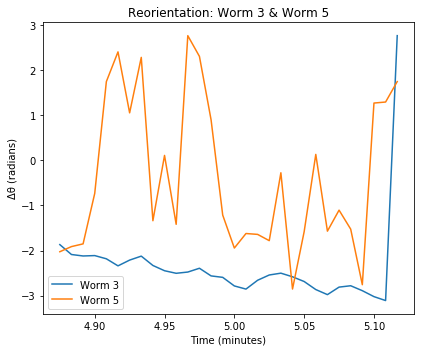

In [110]:
#----------------------------------------reorientation graph for worms 3 & 5 in specific frames------------------------------------------------------------------
frames_per_minute = 120        # frame rate
start_frame_for_reorient = 536   
end_frame_for_reorient = 568
step = 2                       # number of frames between orientation calculations
worms_to_plot = [3, 5]         # worm 3 and worm 5 (0-indexed)
colormap = cm.get_cmap('OrRd', frameSize)



dtheta_final = []

for worm_id in worms_to_plot:
    temp = []
    time_minutes = []
    if worm_id not in worm_tracks:
        continue  # skip if worm not tracked
    
    coords = np.array(worm_tracks[worm_id])

    # only frames defined above
    sub_coords = coords[start_frame_for_reorient:end_frame_for_reorient, :]
    
    for loop_coords in range(len(sub_coords)):
        if loop_coords+step < len(sub_coords):
            time_minutes.append(sub_coords[loop_coords, 0]/frames_per_minute)
            # displacement
            dx = sub_coords[loop_coords+step, 1] - sub_coords[loop_coords, 1]
            #print('dx', dx)
            dy = sub_coords[loop_coords+step, 2] - sub_coords[loop_coords, 2]
            #print('dy', dy)
        
            # Orientation angles
            theta = np.arctan2(dy, dx)
            #print('theta', theta)
            #dtheta = (dtheta + np.pi) % (2 * np.pi) - np.pi  # wrap to (-π, π)
            
            temp.append(theta)
            
    dtheta_final.append(temp)

    

# Plot
plt.figure(figsize=(6, 5))
for worm_id in range(len(dtheta_final)):
    plt.plot(time_minutes, dtheta_final[worm_id], label='Worm '+ str(worms_to_plot[worm_id]) ) # label=f"Worm {worm_id}"
plt.title("Reorientation: Worm 3 & Worm 5")
plt.xlabel("Time (minutes)")
plt.ylabel("Δθ (radians)")
plt.legend()
plt.tight_layout()
plt.show()   
            
        




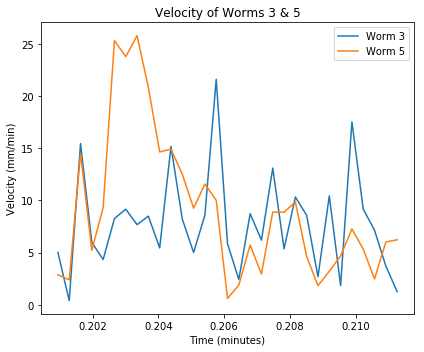

In [111]:
### --------------------velocity graph two specific worms in specific frames-------------------------------------------------
frames_per_minute = 120        # imaging frame rate
start_frame_for_velocity = 536   
end_frame_for_velocity = 568
velocity_final = []

for worm_id in worms_to_plot:
    temp2=[]
    time_minutes_v = []
    if worm_id not in worm_tracks:
        continue
        
    coords = np.array(worm_tracks[worm_id])
    sub_coords = coords[start_frame_for_velocity:end_frame_for_velocity, :] / pixels_per_mm
    for loop_coords in range(len(sub_coords)):
        if loop_coords+1 < len(sub_coords):
            time_minutes_v.append(sub_coords[loop_coords,0]/frames_per_minute)
            # Compute frame to frame displacement (in mm)
            dx = sub_coords[loop_coords+ 1, 1] - sub_coords[loop_coords, 1]
            dy = sub_coords[loop_coords+ 1, 2] - sub_coords[loop_coords, 2]
            distance_mm = np.sqrt(dx**2 + dy**2)
            # Time difference between frames (in minutes)
            time_diff_min = 1.0 / frames_per_minute

         # Compute velocity (mm/min)
            velocity_mm_min = distance_mm / time_diff_min
            temp2.append(velocity_mm_min)
    velocity_final.append(temp2)

plt.figure(figsize=(6, 5))
for worm_id in range(len(velocity_final)):
    plt.plot(time_minutes_v, velocity_final[worm_id], label='Worm '+ str(worms_to_plot[worm_id]) )
plt.title("Velocity of Worms 3 & 5")
plt.xlabel("Time (minutes)")
plt.ylabel("Velocity (mm/min)")
plt.legend()
plt.tight_layout()
plt.show()